In [1]:
# 필요한 라이브러리 로드
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

In [2]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [3]:
df = pd.read_csv("/content/drive/MyDrive/creditcard.csv")

In [4]:
df.shape

(46718, 31)

In [5]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46718 entries, 0 to 46717
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    46718 non-null  int64  
 1   V1      46718 non-null  float64
 2   V2      46718 non-null  float64
 3   V3      46718 non-null  float64
 4   V4      46718 non-null  float64
 5   V5      46718 non-null  float64
 6   V6      46718 non-null  float64
 7   V7      46718 non-null  float64
 8   V8      46718 non-null  float64
 9   V9      46718 non-null  float64
 10  V10     46718 non-null  float64
 11  V11     46718 non-null  float64
 12  V12     46718 non-null  float64
 13  V13     46718 non-null  float64
 14  V14     46718 non-null  float64
 15  V15     46718 non-null  float64
 16  V16     46718 non-null  float64
 17  V17     46718 non-null  float64
 18  V18     46718 non-null  float64
 19  V19     46718 non-null  float64
 20  V20     46718 non-null  float64
 21  V21     46718 non-null  float64
 22

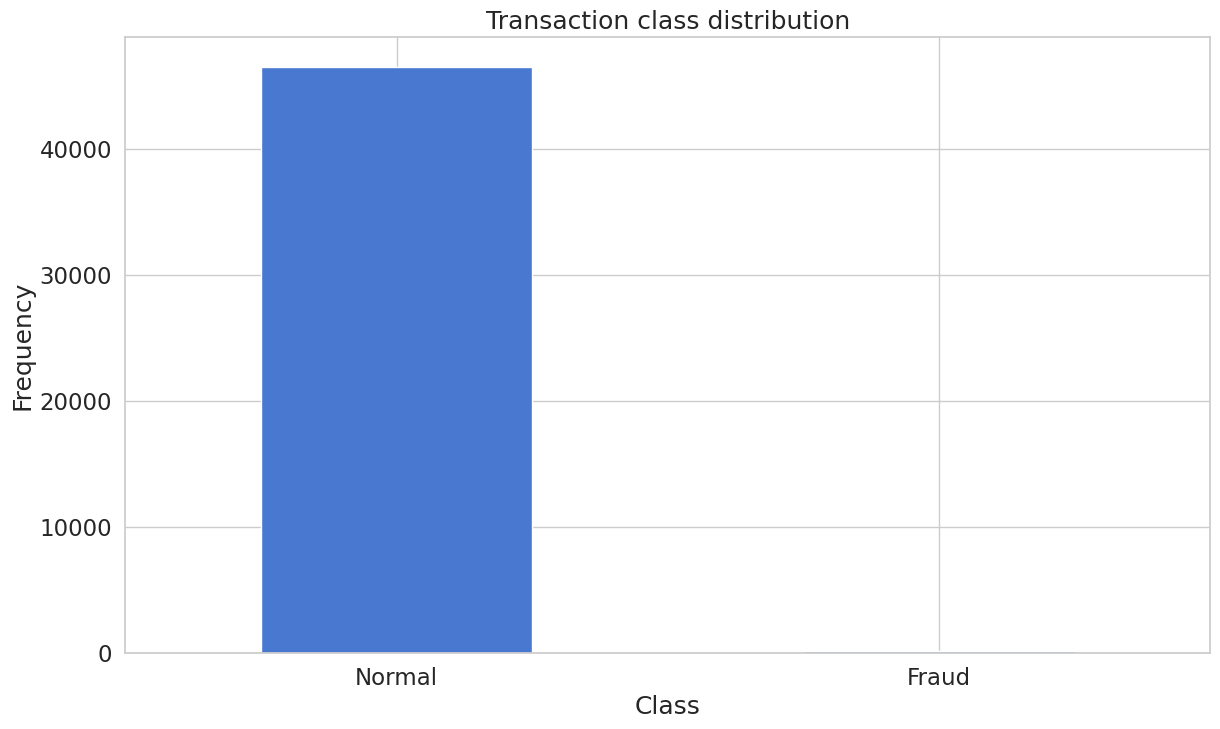

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(143, 31)

In [9]:
normal.shape

(46574, 31)

In [10]:
frauds.Amount.describe()

count     143.000000
mean       96.916713
std       232.503019
min         0.000000
25%         1.000000
50%         7.610000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [11]:
normal.Amount.describe()

count    46574.000000
mean        90.995134
std        240.439094
min          0.000000
25%          7.600000
50%         24.990000
75%         82.837500
max       7879.420000
Name: Amount, dtype: float64

In [12]:
data = df.drop(['Time', 'Amount'], axis=1)

In [31]:
X_train, X_test = train_test_split(data, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)

y_test = X_test['Class'] # 이상치 탐지를 위해 Class값을 미리 y_test에 따로 저장해둔다.
X_test = X_test.drop(['Class'], axis=1) # 오토인코더 목표는 원본데이터 복원이므로 필요없다

X_train = X_train.values
X_test = X_test.values

X_train.shape

(37261, 28)

In [32]:
input_dim = X_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim, ))

encoder = Dense(encoding_dim, activation="tanh",
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

In [33]:
#nb_epoch = 100
nb_epoch = 10
batch_size = 32
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)
history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Epoch 1/10
1048/1048 [==============================] - 6s 4ms/step - loss: 0.9614 - accuracy: 0.3589 - val_loss: 0.8281 - val_accuracy: 0.4763
Epoch 2/10
  45/1048 [>.............................] - ETA: 3s - loss: 0.8939 - accuracy: 0.4715

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1048/1048 [==============================] - 4s 4ms/step - loss: 0.8702 - accuracy: 0.5211 - val_loss: 0.7755 - val_accuracy: 0.5543
Epoch 3/10
1048/1048 [==============================] - 5s 5ms/step - loss: 0.8253 - accuracy: 0.5921 - val_loss: 0.7494 - val_accuracy: 0.6131
Epoch 4/10
1048/1048 [==============================] - 4s 4ms/step - loss: 0.8056 - accuracy: 0.6284 - val_loss: 0.7367 - val_accuracy: 0.6383
Epoch 5/10
1048/1048 [==============================] - 6s 6ms/step - loss: 0.7930 - accuracy: 0.6503 - val_loss: 0.7277 - val_accuracy: 0.6587
Epoch 6/10
1048/1048 [==============================] - 7s 7ms/step - loss: 0.7843 - accuracy: 0.6612 - val_loss: 0.7213 - val_accuracy: 0.6606
Epoch 7/10
1048/1048 [==============================] - 5s 5ms/step - loss: 0.7778 - accuracy: 0.6688 - val_loss: 0.7162 - val_accuracy: 0.6700
Epoch 8/10
1048/1048 [==============================] - 5s 5ms/step - loss: 0.7733 - accuracy: 0.6726 - val_loss: 0.7130 - val_accuracy: 0.6676
Epo

In [34]:
autoencoder = load_model('model.h5')

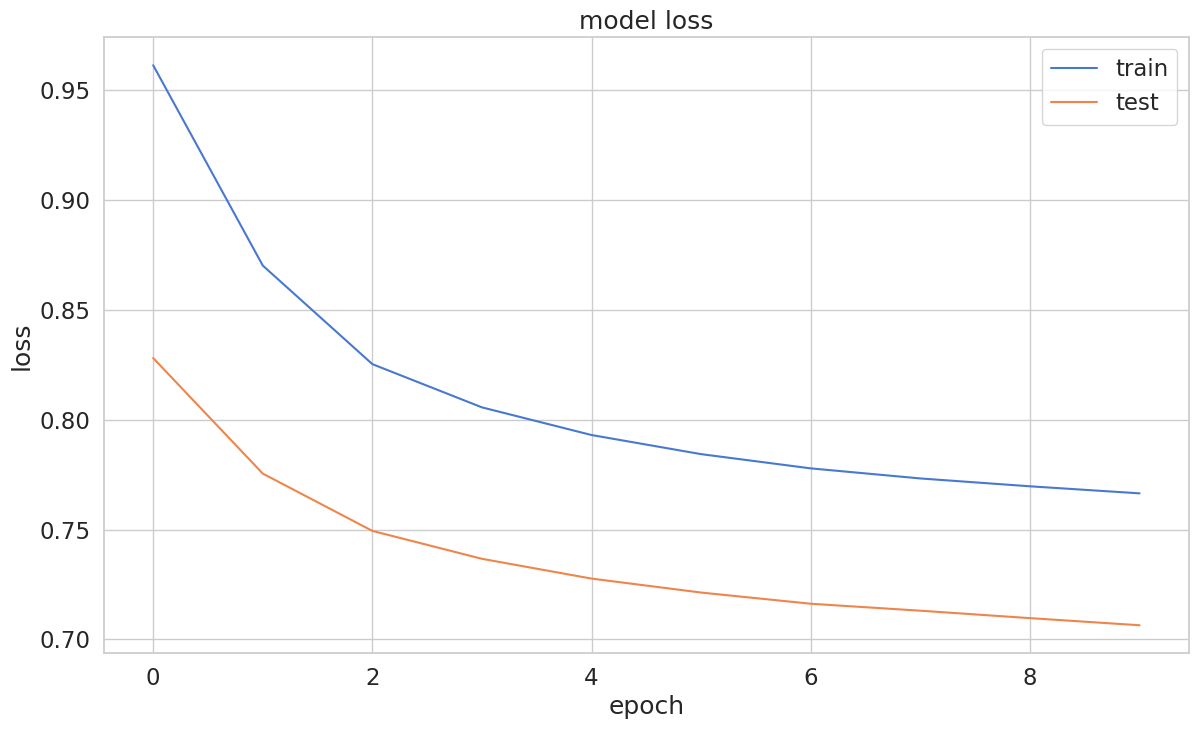

In [35]:

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [36]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

292/292 [==============================] - 1s 2ms/step


,reconstruction_error,true_class
count,9344.000000,9344.000000
mean,0.827663,0.003318
std,3.625515,0.057506
min,0.051692,0.000000
25%,0.236508,0.000000
50%,0.394715,0.000000
75%,0.643838,0.000000
max,94.990462,1.000000


#ROC 곡선 평가

In [38]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

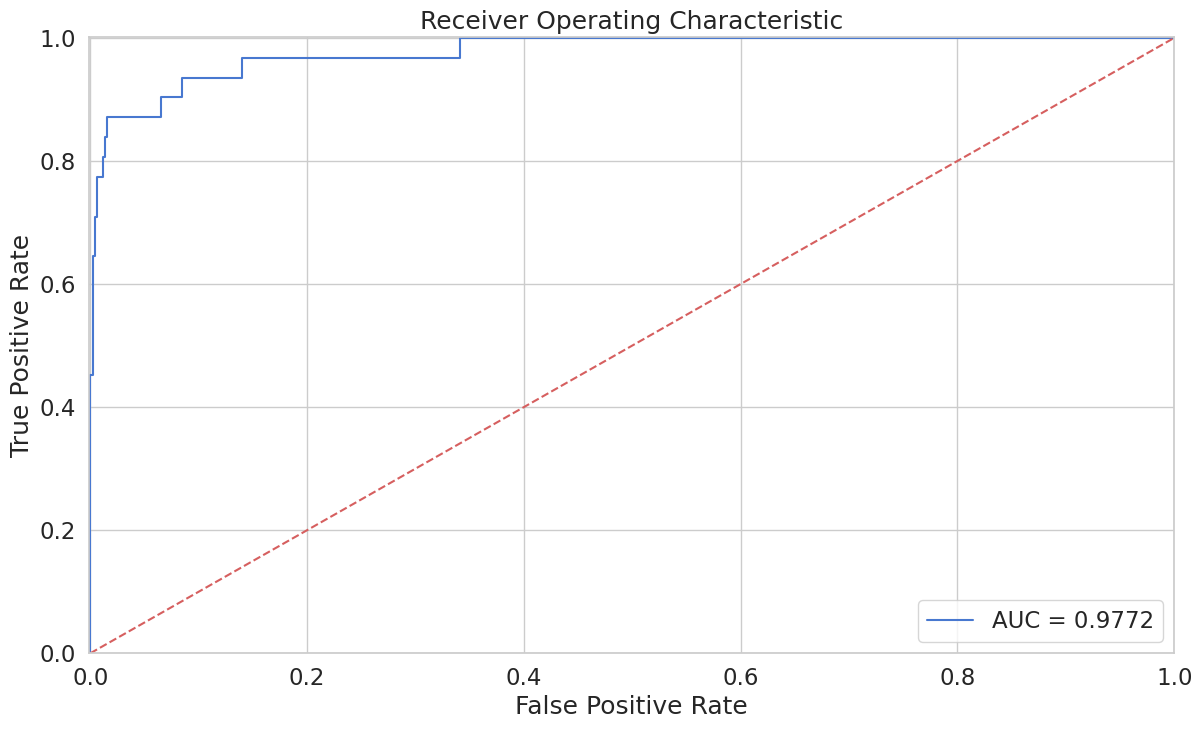

In [39]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

- ROC 곡선은 각 기준치(threshold)가 달라질 때마다 '틀린 것을 맞다고 할 확률'(false positive rate)에 따른 '맞는 것을 맞다고 한 확률'(true positive rate)을 그래프로 그린 것
- 기본적으로, 파란색 곡선이 왼쪽 위 모퉁이에 가까워질수록 좋음

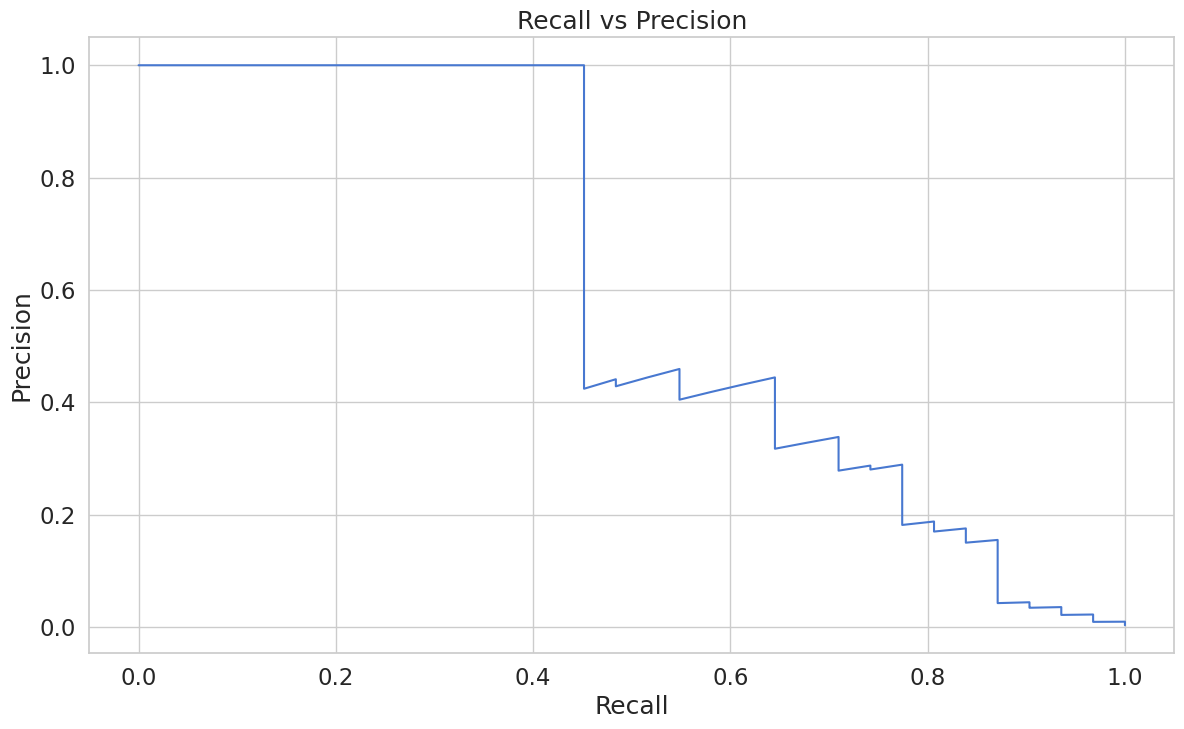

In [40]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

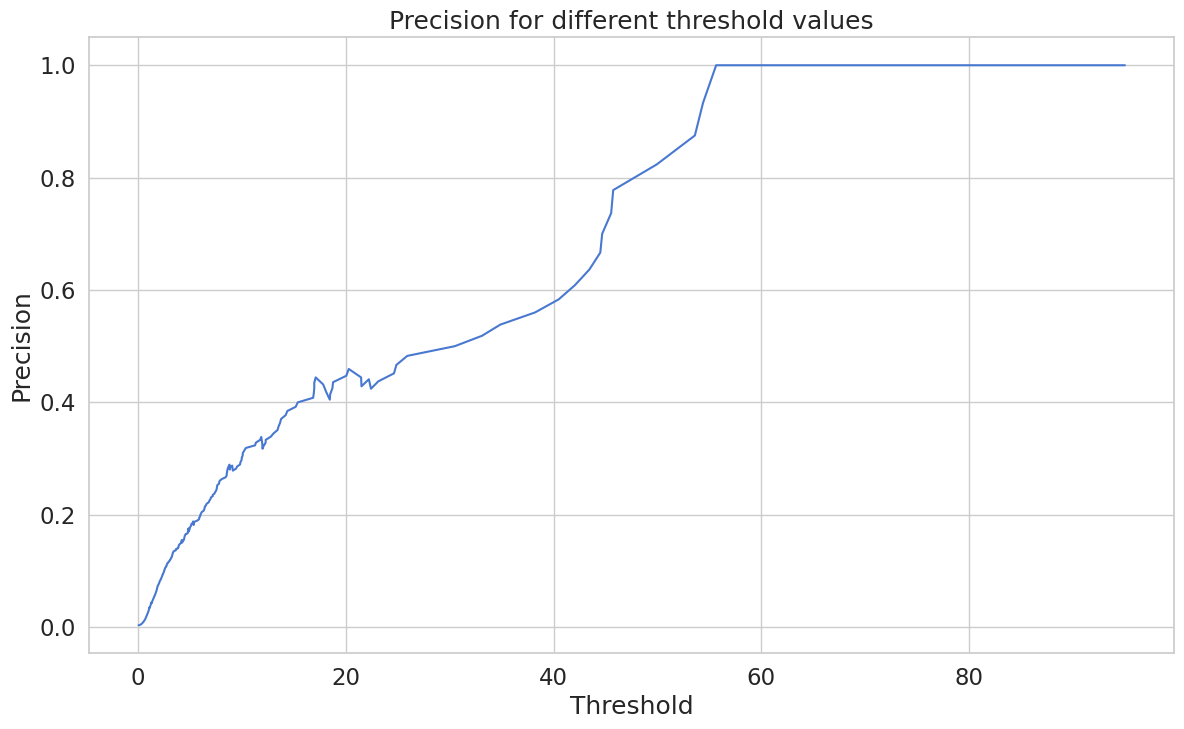

In [41]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

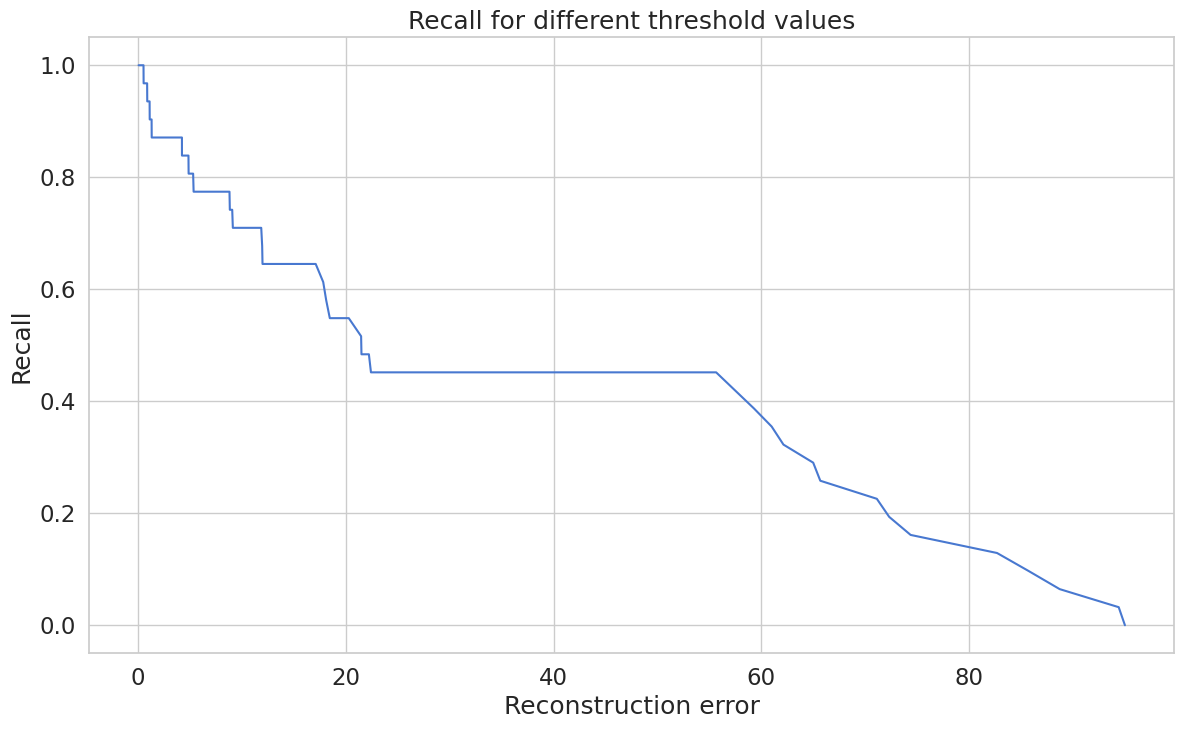

In [42]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

In [43]:
threshold = 2.9

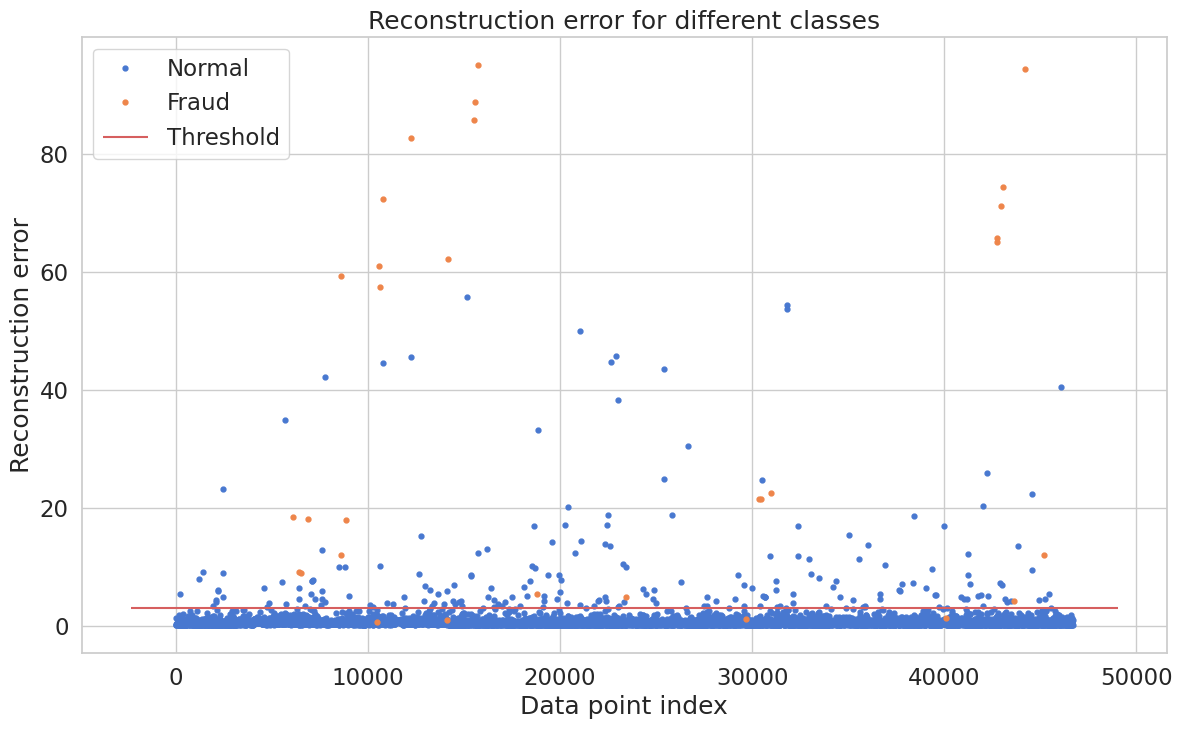

In [44]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

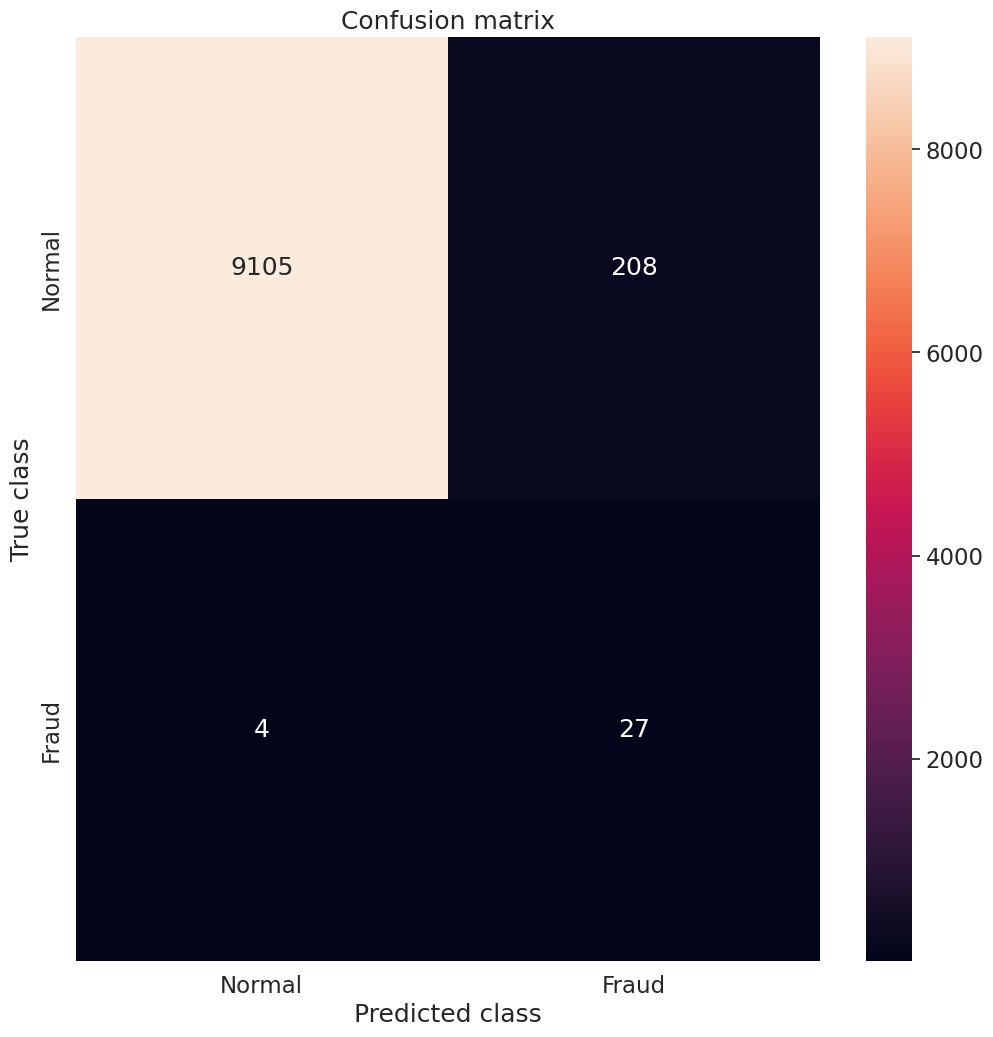

In [45]:
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()